## Imports

In [1]:
import numpy as np
from jax.config import config; config.update("jax_enable_x64", True)
import jax.numpy as jnp
import networkx as nx
from qibo import matrices, optimizers
import matplotlib.pyplot as plt
%matplotlib inline

## MAXcut and Weighted MAXcut Hamiltonians

In [62]:
def maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph).toarray()

    ham = jnp.zeros(shape=(2**nqubits,2**nqubits), dtype=np.float64)
    z = jnp.array([[1,0],[0,-1]], dtype=np.float64)
    iden = jnp.array([[1,0],[0,1]], dtype=np.float64)
    for i in range(nqubits):
        for j in range(nqubits):
            h = jnp.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = jnp.kron(h, z)
                else:
                    h = jnp.kron(h, iden)            
            M = jnp.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * M
            else:
                ham += M
    return - 1/norm * ham    


def weighted_maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    weights = jnp.array([[0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ],
                         [0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152],
                         [0.79172504, 0.52889492, 0.56804456, 0.92559664, 0.07103606],
                         [0.0871293 , 0.0202184 , 0.83261985, 0.77815675, 0.87001215],
                         [0.97861834, 0.79915856, 0.46147936, 0.78052918, 0.11827443]], 
                        dtype=np.float64)
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph).toarray()

    ham = jnp.zeros(shape=(2**nqubits,2**nqubits), dtype=np.float64)
    z = jnp.array([[1,0],[0,-1]], dtype=np.float64)
    iden = jnp.array([[1,0],[0,1]], dtype=np.float64)
    for i in range(nqubits):
        for j in range(nqubits):
            h = jnp.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = jnp.kron(h, z)
                else:
                    h = jnp.kron(h, iden)            
            M = jnp.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * weights[i,j] * M
            else:
                ham += M * weights[i,j]
    return - 1/norm * ham    

## Optimization class

In [35]:
def Qu(beta, r, eps=1e-3):
    return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


class FragmentedQuITE:
    
    def __init__(self, nqubits, hamiltonian, r, b, query, eps=1e-3):
        """Test function for optimization."""
        self.n = nqubits
        self.energy = jnp.linalg.eigvalsh(hamiltonian)
        self.lmin = np.min(self.energy)
        self.lmax = np.max(self.energy)
        self.r = r
        self.b = b
        self.query = query
        self.eps = eps

    def minimize(self, schedule, initial_parameters=None, method='BFGS', options=None):
        """Optimizes scheduling function."""
        from scipy.optimize import minimize
        
        # imposes differences to be positive
        def derivative(p):
            return np.diff([schedule(step/self.r, p) for step in range(1, self.r+1)])
        
        con1 = {'type': 'ineq', 'fun': derivative}
        m = minimize(lambda p, _: self.compute_query(p, schedule),
                        initial_parameters, 
                        method, options=options, constraints=con1)
        return m.fun, m.x        
        
    def compute_query(self, params, schedule):
        """Compute query optimization."""
        beta = np.array([ self.b*schedule(step/self.r, params) for step in range(1, self.r+1)])
        delta_l = (self.lmax-self.lmin)/2
        Qbeta = np.ceil(self.query(np.hstack([beta[0], np.diff(beta)])*delta_l*np.e/2, self.r, self.eps))
        Zbeta = np.sum(np.exp(-beta.reshape(-1,1)[:-1] * self.energy.reshape(1,-1)), axis=1)
        Psbeta = Zbeta / np.exp(-beta[:-1]*self.lmin) / 2**self.n
        Qr = np.sum(Psbeta * Qbeta[1:]) + Qbeta[0]
        Zbeta = np.sum(np.exp(-beta[r-1]*self.energy))
        Psbeta = Zbeta / np.exp(-beta[r-1]*self.lmin) / 2**self.n    
        Q = 1/Psbeta * Qr
        return Q

    def reference_query(self):
        """Return linear query prediction."""
        return self.compute_query(params=None, schedule=lambda t, _: t)
    
    def reference_query_no_fragmentation(self):
        Zbeta = np.sum(np.exp(-beta*self.energy))
        Psbeta = Zbeta * np.exp(beta*self.lmin) / 2**self.n
        bquery = self.query(beta, 1, self.eps)
        Q = 1/Psbeta * bquery
        Qaa = np.sqrt(1/Psbeta) * bquery
        return Q, Qaa 

## Example


Reference value: 55.14033784355961
Optimized value: 54.34097674815433
Best params: [-1.07142847]
Cross-check: 54.34097674815433

Reference value: 55.14033784355961
Optimized value: 51.17589533535576
Best params: [-5.38043234  2.44565084]
Cross-check: 51.17589533535576



<ipython-input-4-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-4-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 55.14033784355961
Optimized value: 47.05174305297194
Best params: [-14.84095793  15.31807799  -5.65011056]
Cross-check: 47.05174305297194



<ipython-input-4-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 55.14033784355961
Optimized value: 43.496917338670116
Best params: [-32.1653551   55.56680409 -45.57110585  14.28545002]
Cross-check: 43.496917338670116


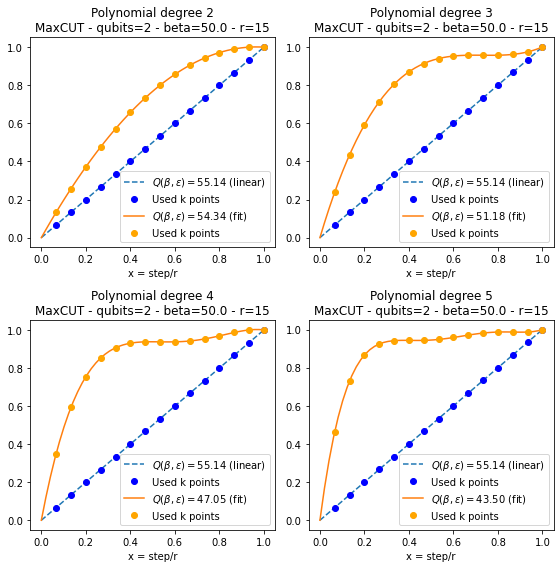

In [7]:
# setup
nqubits = 2
r = 15
beta = 50

model = FragmentedQuITE(maxcut(nqubits, norm=40.0, random_graph=True), r, beta, Qu)

def myschedule(t, params):
    f = sum(p * t ** (i + 2) for i, p in enumerate(params))
    f += (1 - np.sum(params)) * t
    return f
    

plt.figure(figsize=(8,8))
for d in range(4):
    print()
    plt.subplot(2,2,d+1)
    plt.tight_layout()
    initial_guess = np.zeros(d+1)
    initial_guess[0] = 0.1
    result, params = model.minimize(myschedule, initial_parameters=initial_guess, 
                                    method='COBYLA', options={'maxiter':50000})
    reference = model.reference_query()
    print('Reference value:', reference)
    print('Optimized value:', result)
    print('Best params:', params)
    print('Cross-check:', model.compute_query(params, myschedule))

    # plot
    x = np.linspace(0,1,50)
    xr = np.array(range(1,r+1))/r
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    plt.plot(x, [i for i in x], '--', label=r'$Q(\beta,\epsilon)=%.2f$ (linear)' % reference);
    plt.plot(xr, xr, 'o', color='blue', label='Used k points')
    plt.plot(x, [myschedule(i, params) for i in x], label=r'$Q(\beta,\epsilon)=%.2f$ (fit)' % result);
    plt.plot(xr,[myschedule(ixr, params) for ixr in xr], 'o', color='orange', label='Used k points')
    plt.xlabel('x = step/r')
    plt.legend();

## Example 2

<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 39.22904632154152
Optimized value: 30.66116919041711
Best params: [-9.97295968  4.00794168  5.96606137 -4.33883888]
Cross-check: 30.66116919041711
Reference value: 71.13731330403408
Optimized value: 44.486368549883565
Best params: [-32.45074555  55.42963534 -44.58139951  13.61992473]
Cross-check: 44.486368549883565


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 71.13731330403408
Optimized value: 44.486368549883565
Best params: [-32.45074555  55.42963534 -44.58139951  13.61992473]
Cross-check: 44.486368549883565
Reference value: 71.13731330403408
Optimized value: 44.486368549883565
Best params: [-32.45074555  55.42963534 -44.58139951  13.61992473]
Cross-check: 44.486368549883565
Reference value: 39.22904632154152
Optimized value: 30.66116919041711
Best params: [-9.97295968  4.00794168  5.96606137 -4.33883888]
Cross-check: 30.66116919041711


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 412.976585726458
Optimized value: 401.39380159261947
Best params: [-2.39898421  1.23831164  0.84188499 -0.62742249]
Cross-check: 401.39380159261947


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 744.9603470285257
Optimized value: 720.5822766821117
Best params: [-2.0391489   0.81018994  1.4189532  -1.03623585]
Cross-check: 720.5822766821117


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 144.5080878751085
Optimized value: 119.59622625586101
Best params: [-5.2470345   0.96533792  2.47509243 -1.27845721]
Cross-check: 119.59622625586101


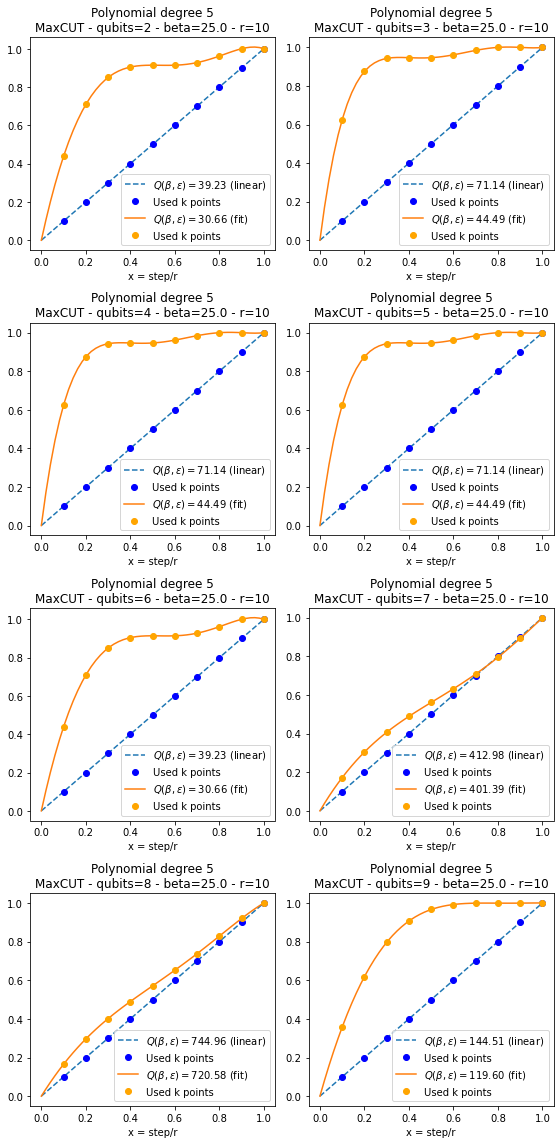

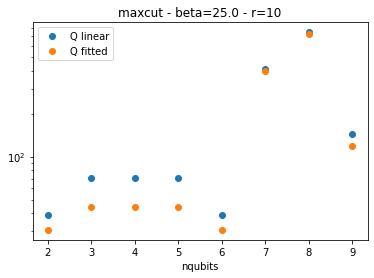

In [41]:
# setup
r = 10
beta = 25

qref = []
qopt = []

plt.figure(figsize=(8,16))
for nqubits in range(2, 10):
    plt.subplot(4,2,nqubits-1)
    plt.tight_layout()    
    
    model = FragmentedQuITE(maxcut(nqubits, norm=40.0, random_graph=True), r, beta, Qu)

    def myschedule(t, params):
        f = sum(p * t ** (i + 2) for i, p in enumerate(params))
        f += (1 - np.sum(params)) * t
        return f

    initial_guess = np.zeros(4)
    initial_guess[0] = 0.1
    result, params = model.minimize(myschedule, initial_parameters=initial_guess, 
                                    method='COBYLA', options={'maxiter':50000})
    reference = model.reference_query()
    print('Reference value:', reference)
    print('Optimized value:', result)
    print('Best params:', params)
    print('Cross-check:', model.compute_query(params, myschedule))
    qref.append(reference)
    qopt.append(result)
    
    # plot
    x = np.linspace(0,1,50)
    xr = np.array(range(1,r+1))/r
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    plt.plot(x, [i for i in x], '--', label=r'$Q(\beta,\epsilon)=%.2f$ (linear)' % reference);
    plt.plot(xr, xr, 'o', color='blue', label='Used k points')
    plt.plot(x, [myschedule(i, params) for i in x], label=r'$Q(\beta,\epsilon)=%.2f$ (fit)' % result);
    plt.plot(xr,[myschedule(ixr, params) for ixr in xr], 'o', color='orange', label='Used k points')
    plt.xlabel('x = step/r')
    plt.legend();
plt.savefig('maxcut_beta%d_r%d_pol%d.png' % (beta, r, len(initial_guess)+1))

plt.figure()
plt.title('maxcut - beta=%.1f - r=%d' % (beta, r))
plt.plot(range(2,10), qref, 'o', label='Q linear')
plt.plot(range(2,10), qopt, 'o', label='Q fitted')
plt.yscale('log')
plt.legend();
plt.xlabel('nqubits')
plt.savefig('all_maxcut_beta%d_r%d_pol%d.png' % (beta, r, len(initial_guess)+1))

## Example 3

Reference value: 5.193893674612351
Optimized value: 5.193893674612351
Best params: [0.1 0.  0.  0. ]
Cross-check: 5.193893674612351
Reference value: 6.19705532772187
Optimized value: 6.19705532772187
Best params: [0.1 0.  0.  0. ]
Cross-check: 6.19705532772187
Reference value: 11.425696597488782
Optimized value: 9.091727995482584
Best params: [-0.11367251 -0.32050877 -0.37392684 -0.40063593]
Cross-check: 9.091727995482584
Reference value: 14.96950434946173
Optimized value: 13.12269509095543
Best params: [-0.11367274 -0.32050876 -0.37392676 -0.40063589]
Cross-check: 13.12269509095543
Reference value: 20.57295205246205
Optimized value: 19.16830167025402
Best params: [-0.11367244 -0.32050878 -0.37392683 -0.40063597]
Cross-check: 19.16830167025402


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 13.204433220700135
Optimized value: 10.929497983867495
Best params: [-3.69952912 -2.22097183  0.20198834  2.2741182 ]
Cross-check: 10.929497983867495


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 22.9948513596238
Optimized value: 17.626905118923506
Best params: [-2.08827723 -1.33307303  0.00842584  1.15986921]
Cross-check: 17.626905118923506
Reference value: 25.178779037674303
Optimized value: 22.355537088501567
Best params: [-3.69955168 -2.22093074  0.20196093  2.27412318]
Cross-check: 22.355537088501567


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: divide by zero encountered in true_divide
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: divide by zero encountered in true_divide
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 33.2259107650509
Optimized value: 27.273695316895903
Best params: [-2.21372911 -1.31531159  0.02813772  1.13997626]
Cross-check: 27.273695316895903
Reference value: 19.675351626391393
Optimized value: 17.143434263164934
Best params: [-2.11865769 -1.38059908 -0.03451741  1.19997961]
Cross-check: 17.143434263164934


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 60.78986728037438
Optimized value: 48.58474655481744
Best params: [-2.22772408 -1.3057083   0.03737425  1.13113684]
Cross-check: 48.58474655481744


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 29.26743933783735
Optimized value: 25.117306000316233
Best params: [-1.28969736 -0.85522761 -0.07765144  0.59911132]
Cross-check: 25.117306000316233


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 30.17213492800561
Optimized value: 27.882474002973062
Best params: [-0.74802568 -0.58733507 -0.13420792  0.29901632]
Cross-check: 27.882474002973062


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 75.54463532732419
Optimized value: 73.69413618644278
Best params: [-2.67476607  0.11445566  0.87875393 -0.31348702]
Cross-check: 73.69413618644278


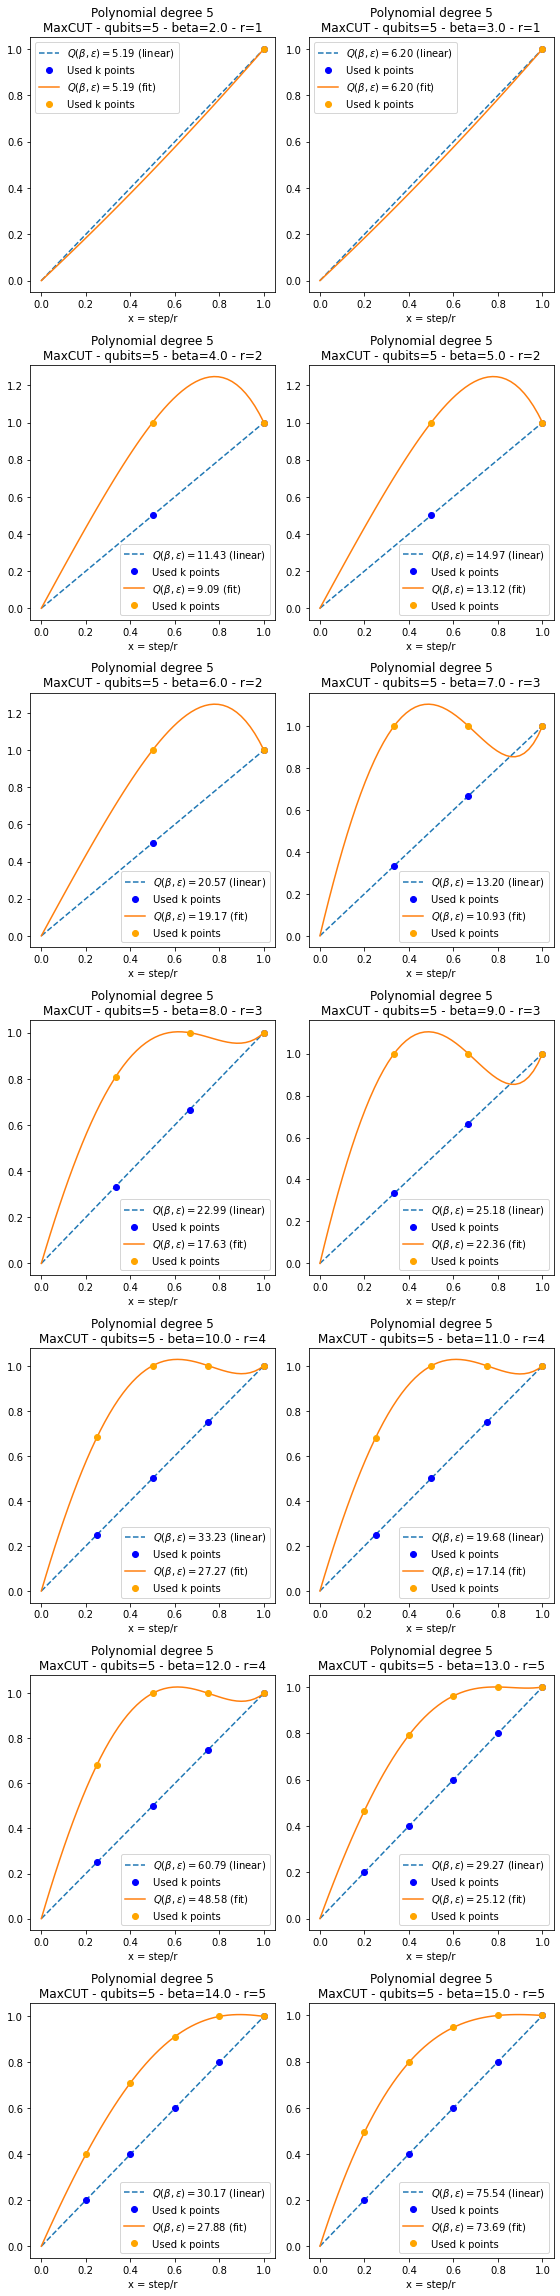

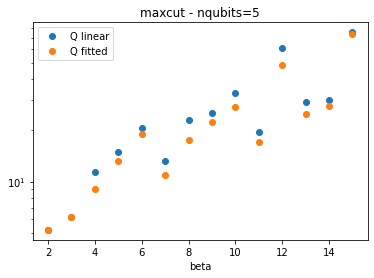

In [58]:
# setup
nqubits = 5

qref = []
qopt = []

plt.figure(figsize=(8,32))
for beta in range(2, 16):    
    plt.subplot(7,2,beta-1)
    plt.tight_layout()    
    r = np.int64(np.ceil(beta/3))
    model = FragmentedQuITE(maxcut(nqubits, norm=40.0, random_graph=True), r, beta, Qu)

    def myschedule(t, params):
        f = sum(p * t ** (i + 2) for i, p in enumerate(params))
        f += (1 - np.sum(params)) * t
        return f

    initial_guess = np.zeros(4)
    initial_guess[0] = 0.1
    result, params = model.minimize(myschedule, initial_parameters=initial_guess, 
                                    method='COBYLA', options={'maxiter':50000})
    reference = model.reference_query()
    print('Reference value:', reference)
    print('Optimized value:', result)
    print('Best params:', params)
    print('Cross-check:', model.compute_query(params, myschedule))
    qref.append(reference)
    qopt.append(result)
    
    # plot
    x = np.linspace(0,1,50)
    xr = np.array(range(1,r+1))/r
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    plt.plot(x, [i for i in x], '--', label=r'$Q(\beta,\epsilon)=%.2f$ (linear)' % reference);
    plt.plot(xr, xr, 'o', color='blue', label='Used k points')
    plt.plot(x, [myschedule(i, params) for i in x], label=r'$Q(\beta,\epsilon)=%.2f$ (fit)' % result);
    plt.plot(xr,[myschedule(ixr, params) for ixr in xr], 'o', color='orange', label='Used k points')
    plt.xlabel('x = step/r')
    plt.legend();
plt.savefig('p2_maxcut_nqubits%d_pol%d.png' % (nqubits, len(initial_guess)+1))


plt.figure()
plt.title('maxcut - nqubits=%d' % nqubits)
plt.plot(range(2, 16), qref, 'o', label='Q linear')
plt.plot(range(2, 16), qopt, 'o', label='Q fitted')
plt.yscale('log')
plt.legend();
plt.xlabel('beta')
plt.savefig('p2_all_maxcut_nqubits%d_pol%d.png' % (nqubits, len(initial_guess)+1))

## Example 4 - Average vs qubits

In [38]:
ntrials = 10

# setup
r = 100
beta = 14
npol = 5

qref = []
qopt = []
qampl = []
qc = []
parameters = []

def myschedule(t, params):
    f = sum(p * t ** (i + 2) for i, p in enumerate(params))
    f += (1 - np.sum(params)) * t
    return f

for nqubits in range(2, 10):
    print('nqubits', nqubits)
    qref.append(np.zeros(ntrials))
    qopt.append(np.zeros(ntrials))
    qampl.append(np.zeros(ntrials))
    qc.append(np.zeros(ntrials))    
    parameters.append(np.zeros(shape=(ntrials,npol-1)))
    for nt in range(ntrials):
        model = FragmentedQuITE(nqubits, maxcut(nqubits, norm=40.0, random_graph=True), r, beta, Qu)
        reference = model.reference_query()
        a_ref, qampl_reference = model.reference_query_no_fragmentation()
        
        initial_guess = np.zeros(npol-1)
        initial_guess[0] = 0.1
        result, params = model.minimize(myschedule, initial_parameters=initial_guess, 
                                        method='COBYLA', options={'maxiter':50000})
        qref[nqubits-2][nt] = reference        
        qopt[nqubits-2][nt] = result
        qampl[nqubits-2][nt] = qampl_reference
        parameters[nqubits-2][nt] = params
        qc[nqubits-2][nt] = a_ref

nqubits 2


<ipython-input-35-cc93ef538dbe>:2: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


nqubits 3
nqubits 4
nqubits 5
nqubits 6
nqubits 7
nqubits 8


<ipython-input-35-cc93ef538dbe>:37: RuntimeWarning: overflow encountered in exp
  Zbeta = np.sum(np.exp(-beta.reshape(-1,1)[:-1] * self.energy.reshape(1,-1)), axis=1)
<ipython-input-35-cc93ef538dbe>:38: RuntimeWarning: overflow encountered in exp
  Psbeta = Zbeta / np.exp(-beta[:-1]*self.lmin) / 2**self.n
<ipython-input-35-cc93ef538dbe>:38: RuntimeWarning: divide by zero encountered in true_divide
  Psbeta = Zbeta / np.exp(-beta[:-1]*self.lmin) / 2**self.n
<ipython-input-35-cc93ef538dbe>:38: RuntimeWarning: invalid value encountered in true_divide
  Psbeta = Zbeta / np.exp(-beta[:-1]*self.lmin) / 2**self.n
/home/carrazza/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/carrazza/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


nqubits 9


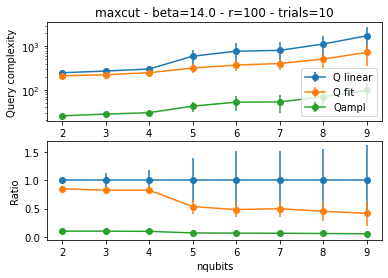

In [41]:
fig, axs = plt.subplots(2)
axs[0].set_title('maxcut - beta=%.1f - r=%d - trials=%d' % (beta, r, ntrials))
axs[0].errorbar(range(2,10), np.mean(qref, axis=1), 
             yerr=np.std(qref, axis=1), marker='o', label='Q linear')
axs[0].errorbar(range(2,10), np.nanmean(qopt, axis=1), 
             yerr=np.nanstd(qopt, axis=1), marker='o', label='Q fit')
axs[0].errorbar(range(2,10), np.nanmean(qampl, axis=1), 
             yerr=np.nanstd(qampl, axis=1), marker='o', label='Qampl')
axs[0].set_yscale('log')
axs[0].legend();
axs[0].set_ylabel('Query complexity')
axs[1].errorbar(range(2,10), np.mean(qref, axis=1)/np.mean(qref, axis=1), 
             yerr=np.std(qref, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].errorbar(range(2,10), np.nanmean(qopt, axis=1)/np.mean(qref, axis=1), 
             yerr=np.nanstd(qopt, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].errorbar(range(2,10), np.nanmean(qampl, axis=1)/np.mean(qref, axis=1), 
             yerr=np.nanstd(qampl, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].set_xlabel('nqubits')
axs[1].set_ylabel('Ratio');
plt.savefig('avg_maxcut_beta%d_r%d_pol5.png' % (beta, r), bbox_inches='tight')

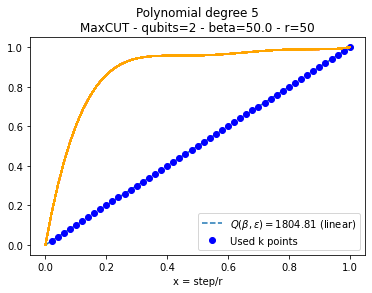

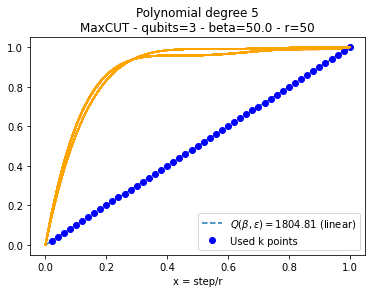

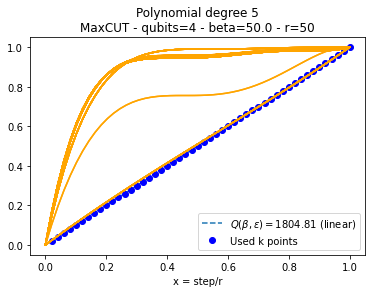

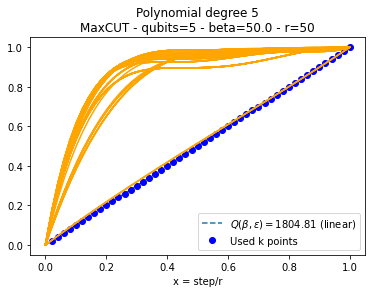

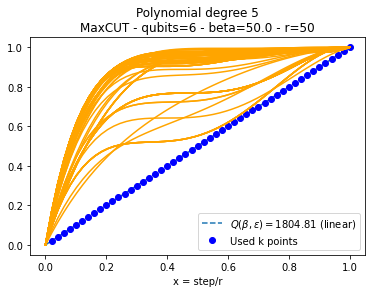

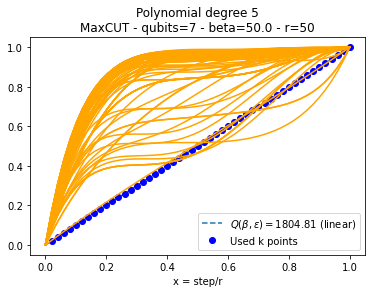

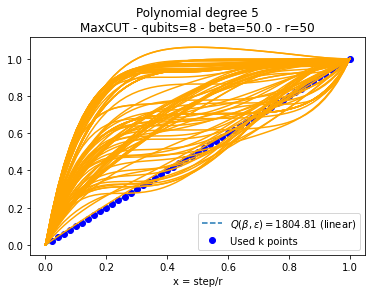

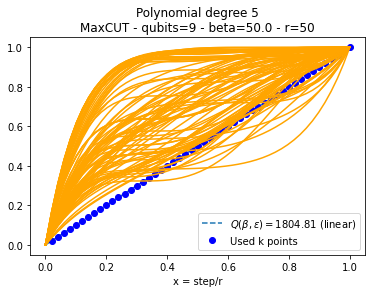

In [48]:
# plot
x = np.linspace(0,1,50)
xr = np.array(range(1,r+1))/r
for nqubits in range(2, 10):
    plt.figure()
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    plt.plot(x, [i for i in x], '--', label=r'$Q(\beta,\epsilon)=%.2f$ (linear)' % reference);
    plt.plot(xr, xr, 'o', color='blue', label='Used k points')
    for j in range(parameters[nqubits-2].shape[0]):
        plt.plot(x, [myschedule(i, parameters[nqubits-2][j]) for i in x], color='orange');
        #plt.plot(xr,[myschedule(ixr, parameters[nqubits-2][j]) for ixr in xr], 'o', color='orange')
    plt.xlabel('x = step/r')
    plt.legend();

## Example 5 - Average vs beta

In [63]:
# setup
ntrials = 10
nqubits = 5
npol = 5

qref = []
qopt = []
qampl = []
qc = []
parameters = []

def myschedule(t, params):
    f = sum(p * t ** (i + 2) for i, p in enumerate(params))
    f += (1 - np.sum(params)) * t
    return f

beta_range = range(2, 51)
for beta in beta_range:   
    #r = np.int64(np.ceil(beta/3))
    #r = np.int64(np.ceil(beta/2))
    r = np.int64(np.ceil(2*beta))
    qref.append(np.zeros(ntrials))
    qopt.append(np.zeros(ntrials))
    qampl.append(np.zeros(ntrials))
    qc.append(np.zeros(ntrials))
    parameters.append(np.zeros(shape=(ntrials, npol-1)))
    print('beta', beta)
    
    for nt in range(ntrials):
        model = FragmentedQuITE(nqubits, weighted_maxcut(nqubits, norm=40.0, 
                                random_graph=True), r, beta, Qu)
        reference = model.reference_query()
        a_ref, ampl_ref = model.reference_query_no_fragmentation()

        initial_guess = np.zeros(npol-1)
        initial_guess[0] = 0.1
        result, params = model.minimize(myschedule, initial_parameters=initial_guess, 
                                        method='COBYLA', options={'maxiter':50000})

        qref[beta-2][nt] = reference        
        qopt[beta-2][nt] = result
        qampl[beta-2][nt] = ampl_ref
        parameters[beta-2][nt] = params
        qc[beta-2][nt] = a_ref

beta 2


<ipython-input-35-cc93ef538dbe>:2: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-35-cc93ef538dbe>:37: RuntimeWarning: overflow encountered in exp
  Zbeta = np.sum(np.exp(-beta.reshape(-1,1)[:-1] * self.energy.reshape(1,-1)), axis=1)
<ipython-input-35-cc93ef538dbe>:38: RuntimeWarning: overflow encountered in exp
  Psbeta = Zbeta / np.exp(-beta[:-1]*self.lmin) / 2**self.n
<ipython-input-35-cc93ef538dbe>:38: RuntimeWarning: invalid value encountered in true_divide
  Psbeta = Zbeta / np.exp(-beta[:-1]*self.lmin) / 2**self.n


beta 3
beta 4
beta 5
beta 6
beta 7
beta 8


<ipython-input-35-cc93ef538dbe>:38: RuntimeWarning: divide by zero encountered in true_divide
  Psbeta = Zbeta / np.exp(-beta[:-1]*self.lmin) / 2**self.n


beta 9
beta 10
beta 11
beta 12
beta 13
beta 14
beta 15
beta 16


<ipython-input-35-cc93ef538dbe>:38: RuntimeWarning: overflow encountered in true_divide
  Psbeta = Zbeta / np.exp(-beta[:-1]*self.lmin) / 2**self.n


beta 17
beta 18
beta 19
beta 20
beta 21
beta 22
beta 23
beta 24
beta 25
beta 26
beta 27
beta 28
beta 29
beta 30
beta 31
beta 32
beta 33
beta 34
beta 35
beta 36
beta 37
beta 38
beta 39
beta 40
beta 41


<ipython-input-35-cc93ef538dbe>:39: RuntimeWarning: invalid value encountered in multiply
  Qr = np.sum(Psbeta * Qbeta[1:]) + Qbeta[0]
/home/carrazza/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


beta 42
beta 43
beta 44
beta 45
beta 46
beta 47
beta 48
beta 49
beta 50


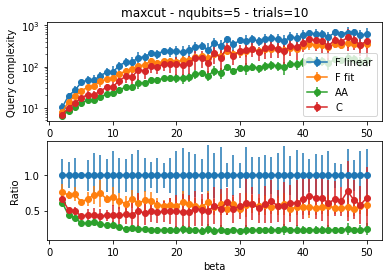

In [64]:
fig, axs = plt.subplots(2)
axs[0].set_title('maxcut - nqubits=%d - trials=%d' % (nqubits, ntrials))
axs[0].errorbar(beta_range, np.mean(qref, axis=1), 
             yerr=np.std(qref, axis=1), marker='o', label='F linear')
axs[0].errorbar(beta_range, np.nanmean(qopt, axis=1), 
             yerr=np.nanstd(qopt, axis=1), marker='o', label='F fit')
axs[0].errorbar(beta_range, np.nanmean(qampl, axis=1), 
             yerr=np.nanstd(qampl, axis=1), marker='o', label='AA')
axs[0].errorbar(beta_range, np.nanmean(qc, axis=1), 
             yerr=np.nanstd(qc, axis=1), marker='o', label='C')
axs[0].set_yscale('log')
axs[0].legend();
axs[0].set_ylabel('Query complexity')
axs[1].errorbar(beta_range, np.mean(qref, axis=1)/np.mean(qref, axis=1), 
             yerr=np.std(qref, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].errorbar(beta_range, np.nanmean(qopt, axis=1)/np.mean(qref, axis=1), 
             yerr=np.nanstd(qopt, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].errorbar(beta_range, np.nanmean(qampl, axis=1)/np.mean(qref, axis=1), 
             yerr=np.nanstd(qampl, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].errorbar(beta_range, np.nanmean(qc, axis=1)/np.mean(qref, axis=1), 
             yerr=np.nanstd(qc, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].set_xlabel('beta')
axs[1].set_ylabel('Ratio');
plt.savefig('avg_maxcut_nqubits%d_pol5.png' % (nqubits), bbox_inches='tight')